<h1>Sound Classification - part 3</h1>

In this part we will add new features and check if they can improve our process. We will extact few features from audio signals in time domain and in frequency domain. Then we will make a features selection.</br>
Let's start from importing required libraries and reading metadata file and other data saved in part 2.

In [1]:
import pandas as pd
pd.options.display.max_columns = 500
import librosa as lb
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# import IPython.display as ipd
from scipy.stats import skew, kurtosis
import pickle
import time

import warnings
warnings.filterwarnings("ignore")

To differentiate MFCC features from new features we will load it as X_mfcc

In [2]:
# Loading saved X (features) and Y (labels) from files
with open('part1_X.pickle', 'rb') as f:
            X_mfcc = pickle.load(f)
with open('part1_Y.pickle', 'rb') as f:
            Y_mfcc = pickle.load(f)

# read metadata writen to file in part 1
with open('part1_df.pickle', 'rb') as f:
            df = pickle.load(f)

df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class,channel_count,sampling_rate
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark,2,44100
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing,2,44100
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing,2,44100
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing,2,44100
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing,2,44100


<h1> EXTRACTING FEATURES IN TIME DOMAIN</h1>

We will extract features from signal energy, signal envelope and from the zero crossing rate.
In general we will make a smaller pieces of the excerpts called frames. Than we will  calculate the characteristics for every frame so we get the list of values. Those values will show how the charakteristics are changing in time for considered excerpt. Then we calculate first and second derivative of them. As the features we will take some statistical data from the charakteristics and their derivatives.</br>
As we don't want to lose information we will process audio with samle rate 44100 Hz.

<h2> Features extracted from energy in time domain </h2>
Let's take a look at audio example ones again.

Text(0.5, 1.0, 'Sample audio')

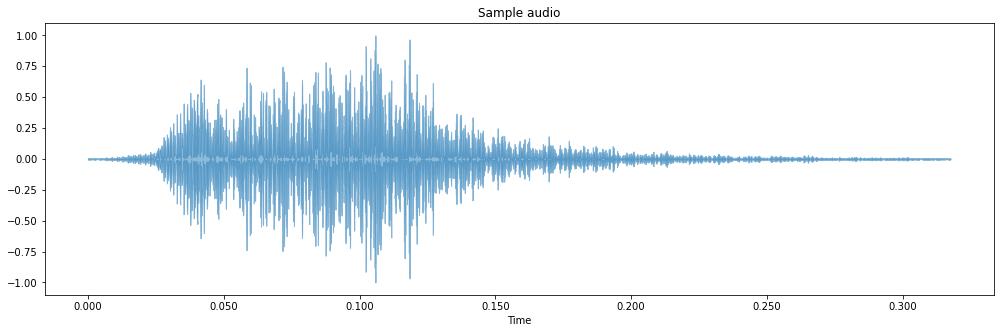

In [3]:
#getting the file name from dataset metadata
file_path = 'fold' + str(df.iloc[0]['fold']) + '/' + df.iloc[0]['slice_file_name']

#geting audio as samples list, the audio is converted to mono and resampled to 44100 if needed
y, sr = lb.load(file_path, mono=True, sr=44100)

#plot audio
plt.figure(figsize=(17,5))
librosa.display.waveshow(y, sr=sr, alpha=0.5)
plt.title('Sample audio')

To extract features related to the signal energy we will use librosa library and the function librosa.feature.rms(). At firs we will plot the rms and it's derivatives.

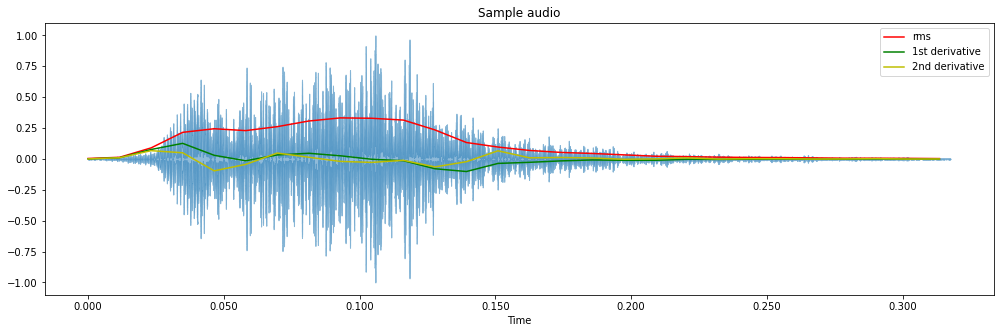

In [4]:
FRAME_LENGTH = 1024 #it gives 23,22 ms of audio duration what can be noticable by human, we also want the frame size to be
#the power of 2 for fft
HOP_LENGTH = 512 #the frames will overlap by the half of frame width

#get rms for our audio
rms = librosa.feature.rms(y=y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)[0]

if len(rms)<2: rms.append(0) # we need at least 2 elements to calculate delta_rms
delta_rms = [0]
delta_rms.extend([rms[i+1]-rms[i] for i in range(len(rms)-1)])
if len(delta_rms)<2: delta_rms.append(0) # we need at least 2 elements to calculate delta2_rms
delta2_rms = [0]
delta2_rms.extend([delta_rms[i+1]-delta_rms[i] for i in range(len(delta_rms)-1)])
if len(delta2_rms)<2: delta2_rms.append(0)  # we need at least 2 elements to avoid errors during calculating any statistics
                                            #for delta2_rms

#set the time axis for rms plots
frames = range(len(rms))
t = lb.frames_to_time(frames, sr=sr, hop_length=HOP_LENGTH)
frames = range(len(delta_rms))
t2 = lb.frames_to_time(frames, sr=sr, hop_length=HOP_LENGTH)
frames = range(len(delta2_rms))
t3 = lb.frames_to_time(frames, sr=sr, hop_length=HOP_LENGTH)

#plot rms curve
plt.figure(figsize=(17,5))
librosa.display.waveshow(y, sr=sr, alpha=0.5)
plt.plot(t, rms, color='r', label='rms')
plt.plot(t2, delta_rms, color='g', label='1st derivative')
plt.plot(t3, delta2_rms, color='y', label='2nd derivative')
plt.title('Sample audio')
plt.legend()

In [5]:
def get_rms_features(y, frame_l, hop_l):
    #get rms for our audio
    rms = librosa.feature.rms(y=y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)[0]

    if len(rms)<2: rms.append(0) # we need at least 2 elements to calculate delta_rms
    delta_rms = [0] #1st element in derivative will be equal 0
    delta_rms.extend([rms[i+1]-rms[i] for i in range(len(rms)-1)])
    delta2_rms = [0] #1st element in derivative will be equal 0
    delta2_rms.extend([delta_rms[i+1]-delta_rms[i] for i in range(len(delta_rms)-1)])
    
    features = {}
    prefixes = ['', 'delta_', 'delta2_']
    data = [rms, delta_rms, delta2_rms]
    for i in range(3):
        features[prefixes[i]+'rms_mean'] = np.mean(data[i])
        features[prefixes[i]+'rms_median'] = np.median(data[i])
        features[prefixes[i]+'rms_min'] = np.min(data[i])
        features[prefixes[i]+'rms_max'] = np.max(data[i])
        features[prefixes[i]+'rms_std'] = np.std(data[i])
        features[prefixes[i]+'rms_skew'] = skew(data[i])
        features[prefixes[i]+'rms_kurtosis'] = kurtosis(data[i])
    return features

#get_rms_features(y, FRAME_LENGTH, HOP_LENGTH)

A sketch of function that will extract all features.

In [6]:
def get_features(data_frame, features_type='all'):
    FRAME_LENGTH = 1024 #it gives 23,22 ms of audio duration what can be noticable by human, we also want the frame size to be
    #the power of 2 for fft
    HOP_LENGTH = 512 #the frames will overlap by the half of frame width
    
    classes = []
    
    for i in range(len(data_frame)):
        features = {}
        
        #getting the file name from dataset metadata
        file_path = 'fold' + str(data_frame.iloc[i]['fold']) + '/' + data_frame.iloc[i]['slice_file_name']

        #geting audio as samples list, the audio is converted to mono and resampled to 44100 if needed
        y, sr = lb.load(file_path, mono=True, sr=44100)
        
        #for the short audio we will append zeros to get 4 seconds audio
        if len(y)<4*sr:
            y = np.concatenate((y, np.zeros(4*sr-len(y))))
        
        #rms_features
        if (features_type == 'all') or (features_type == 'rms'):
            feat = get_rms_features(y, FRAME_LENGTH, HOP_LENGTH)
            features = dict(features, **feat)
        
        #here is a place for more features - to be continued
        #...
        #...
        
        temp = pd.DataFrame(data=feat, index=[data_frame.index[i]]) #we need to keep original index value from meta-data file
        
        if i==0:
            X = temp
        else:
            X = pd.concat([X, temp])
            
        classes.append(data_frame.iloc[i]['class'])
        
    Y = pd.Series(classes, name='class', index=X.index)
    return X, Y

Let's extract rms features using our function.

In [7]:
# extracting rms features
# X_rms, Y_rms = get_features(df, 'rms')

# save features to file
# with open('X_rms.pickle', 'wb') as f:
#             pickle.dump(X_rms, f)

# with open('Y_rms.pickle', 'wb') as f:
#             pickle.dump(Y_rms, f)

# load features from file
with open('X_rms.pickle', 'rb') as f:
            X_rms = pickle.load(f)

with open('Y_rms.pickle', 'rb') as f:
            Y_rms = pickle.load(f)

Let's check how will Randow Forest Classifier perform using this features - scaled and unscaled.

In [8]:
### create scaled features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# fit_transform() returns numpy.ndarray, if we want to keep indexes and column names, we do it like this
X_rms_scaled = pd.DataFrame(scaler.fit_transform(X_rms), index=X_rms.index, columns=X_rms.columns)

### spliting train and test data
train_X_rms = X_rms.loc[df['fold']!=10]
train_X_rms_scaled = X_rms_scaled.loc[df['fold']!=10]
train_Y_rms = Y_rms.loc[df['fold']!=10]
test_X_rms = X_rms.loc[df['fold']==10]
test_X_rms_scaled = X_rms_scaled.loc[df['fold']==10]
test_Y_rms = Y_rms.loc[df['fold']==10]
df2 = df.loc[df['fold']!=10]

### create our cross_val function
def my_cross_val_using_9_folds(clf, X, data):
    test_score = []
    train_score = []
    if len(X.index) != len(data.index):
        print("Indexes of X and data are not the same length!!!")
        return test_score, train_score
    if (X.index != data.index).any():
        print("Indexes of X and data are not equal!!!")
        return test_score, train_score
    for i in range(1,10):
        X_train = X.loc[data['fold']!=i]
        Y_train = data.loc[data['fold']!=i]['class']
        X_test = X.loc[data['fold']==i]
        Y_test = data.loc[data['fold']==i]['class']
        clf.fit(X_train, Y_train)
        Y_pred = clf.predict(X_test)
        temp = np.sum(Y_pred==Y_test)/len(Y_test)
        test_score.append(temp)
        Y_pred = clf.predict(X_train)
        temp = np.sum(Y_pred==Y_train)/len(Y_train)
        train_score.append(temp)
    return test_score, train_score

# ### create Random Forest classifier and evaluate it
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_jobs=-1, n_estimators=500, random_state=44)

# unscaled features
scores, _ = my_cross_val_using_9_folds(rf_clf, train_X_rms, df2)
print('Random Forest average score - X unscaled: ', np.mean(scores))

# scaled features
scores, _ = my_cross_val_using_9_folds(rf_clf, train_X_rms_scaled, df2)
print('Random Forest average score - X scaled: ', np.mean(scores))

Random Forest average score - X unscaled:  0.47852986386188967
Random Forest average score - X scaled:  0.48198661979272356


<h2> Features extracted from amplitude envelope in time domain </h2>
To extract features related to the signal amplitude envelope we will use custom function amplitude_envelope().
The amplidute envelope is calculated as the maximum value of the signal in current frame.

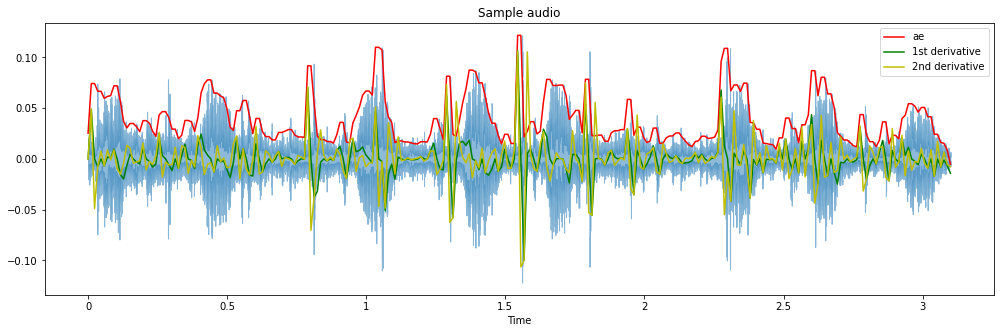

In [9]:
def amplitude_envelope(signal, frame_size, hope_length):
    return np.array([max(signal[i:i+frame_size]) for i in range(0, len(signal), hope_length)])

FRAME_LENGTH = 1024 #it gives 23,22 ms of audio duration what can be noticable by human, we also want the frame size to be
#the power of 2 for fft
HOP_LENGTH = 512 #the frames will overlap by the half of frame width

#getting the file name from dataset metadata
file_path = 'fold' + str(df.iloc[100]['fold']) + '/' + df.iloc[100]['slice_file_name']

#geting audio as samples list, the audio is converted to mono and resampled to 44100 if needed
y, sr = lb.load(file_path, mono=True, sr=44100)

#get ae for our audio
ae = amplitude_envelope(y, FRAME_LENGTH, HOP_LENGTH)

if len(ae)<2: ae.append(0) # we need at least 2 elements to calculate delta_ae
delta_ae = [0]
delta_ae.extend([ae[i+1]-ae[i] for i in range(len(ae)-1)])
if len(delta_ae)<2: delta_ae.append(0) # we need at least 2 elements to calculate delta2_ae
delta2_ae = [0]
delta2_ae.extend([delta_ae[i+1]-delta_ae[i] for i in range(len(delta_ae)-1)])
if len(delta2_ae)<2: delta2_ae.append(0)  # we need at least 2 elements to avoid errors during calculating any statistics
                                            #for delta2_ae

#set the time axis for ae plots
frames = range(len(ae))
t = lb.frames_to_time(frames, sr=sr, hop_length=HOP_LENGTH)
frames = range(len(delta_ae))
t2 = lb.frames_to_time(frames, sr=sr, hop_length=HOP_LENGTH)
frames = range(len(delta2_ae))
t3 = lb.frames_to_time(frames, sr=sr, hop_length=HOP_LENGTH)

#plot ae curve
plt.figure(figsize=(17,5))
librosa.display.waveshow(y, sr=sr, alpha=0.5)
plt.plot(t, ae, color='r', label='ae')
plt.plot(t2, delta_ae, color='g', label='1st derivative')
plt.plot(t3, delta2_ae, color='y', label='2nd derivative')
plt.title('Sample audio')
plt.legend()

Let's write a function that will return some features extracted from amplitude envelope and amplitude envelope's derivatives

In [10]:
def get_ae_features(y, frame_l, hop_l):
    #get ae for our audio
    ae = amplitude_envelope(y, frame_l, hop_l)

    if len(ae)<2: ae.append(0) # we need at least 2 elements to calculate delta_ae
    delta_ae = [0] #1st element in derivative will be equal 0
    delta_ae.extend([ae[i+1]-ae[i] for i in range(len(ae)-1)])
    delta2_ae = [0] #1st element in derivative will be equal 0
    delta2_ae.extend([delta_ae[i+1]-delta_ae[i] for i in range(len(delta_ae)-1)])
    
    features = {}
    prefixes = ['', 'delta_', 'delta2_']
    data = [ae, delta_ae, delta2_ae]
    for i in range(3):
        features[prefixes[i]+'ae_mean'] = np.mean(data[i])
        features[prefixes[i]+'ae_median'] = np.median(data[i])
        features[prefixes[i]+'ae_min'] = np.min(data[i])
        features[prefixes[i]+'ae_max'] = np.max(data[i])
        features[prefixes[i]+'ae_std'] = np.std(data[i])
        features[prefixes[i]+'ae_skew'] = skew(data[i])
        features[prefixes[i]+'ae_kurtosis'] = kurtosis(data[i])
    return features

# get_ae_features(y, FRAME_LENGTH, HOP_LENGTH)

Now we can modify our 'get_features' function that it could extract also features related to amplidute envelope.

In [11]:
def get_features(data_frame, features_type='all'):
    FRAME_LENGTH = 1024 #it gives 23,22 ms of audio duration what can be noticable by human, we also want the frame size to be
    #the power of 2 for fft
    HOP_LENGTH = 512 #the frames will overlap by the half of frame width
    
    classes = []
    
    for i in range(len(data_frame)):
        features = {}
        
        #getting the file name from dataset metadata
        file_path = 'fold' + str(data_frame.iloc[i]['fold']) + '/' + data_frame.iloc[i]['slice_file_name']

        #geting audio as samples list, the audio is converted to mono and resampled to 44100 if needed
        y, sr = lb.load(file_path, mono=True, sr=44100)
        
        #for the short audio we will append zeros to get 4 seconds audio
        y = np.concatenate((y, np.zeros(4*sr)))
        y = y[0:4*sr]           
        
        #rms_features
        if (features_type=='all') or (features_type=='rms'):
            feat = get_rms_features(y, FRAME_LENGTH, HOP_LENGTH)
            features = dict(features, **feat)
        
        #ae_features
        if (features_type=='all') or (features_type=='ae'):
            feat = get_ae_features(y, FRAME_LENGTH, HOP_LENGTH)
            features = dict(features, **feat)
        
        #here is a place for more features - to be continued
        #...
        #...
        
        temp = pd.DataFrame(data=features, index=[data_frame.index[i]]) #we need to keep original index value from meta-data file
        
        if i==0:
            X = temp
        else:
            X = pd.concat([X, temp])
            
        classes.append(data_frame.iloc[i]['class'])
        
    Y = pd.Series(classes, name='class', index=X.index)
    return X, Y

In [12]:
# extracting ae features
# X_ae, Y_ae = get_features(df, 'ae')

# save features to file
# with open('X_ae.pickle', 'wb') as f:
#             pickle.dump(X_ae, f)

# with open('Y_ae.pickle', 'wb') as f:
#             pickle.dump(Y_ae, f)

# load features from file
with open('X_ae.pickle', 'rb') as f:
            X_ae = pickle.load(f)

with open('Y_ae.pickle', 'rb') as f:
            Y_ae = pickle.load(f)

Let's check how will Randow Forest Classifier preform using this features - scaled and unscaled.

In [13]:
### create scaled features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# fit_transform() returns numpy.ndarray, if we want to keep indexes and column names, we do it like this
X_ae_scaled = pd.DataFrame(scaler.fit_transform(X_ae), index=X_ae.index, columns=X_ae.columns)

### spliting train and test data
train_X_ae = X_ae.loc[df['fold']!=10]
train_X_ae_scaled = X_ae_scaled.loc[df['fold']!=10]
train_Y_ae = Y_ae.loc[df['fold']!=10]
test_X_ae = X_ae.loc[df['fold']==10]
test_X_ae_scaled = X_ae_scaled.loc[df['fold']==10]
test_Y_ae = Y_ae.loc[df['fold']==10]

### create Random Forest classifier and evaluate it
rf_clf = RandomForestClassifier(n_jobs=-1, n_estimators=500, random_state=44)

# unscaled features
scores, _ = my_cross_val_using_9_folds(rf_clf, train_X_ae, df2)
print('Random Forest average score - X unscaled: ', np.mean(scores))

# scaled features
scores, _ = my_cross_val_using_9_folds(rf_clf, train_X_ae_scaled, df2)
print('Random Forest average score - X scaled: ', np.mean(scores))

Random Forest average score - X unscaled:  0.4483916298028776
Random Forest average score - X scaled:  0.44597693050218673


<h2> Features extracted from zero rate crossing in time domain </h2>
To extract features related to the signal zero rate crossing we will use librosa library and the function librosa.feature.zero_crossing_rate()

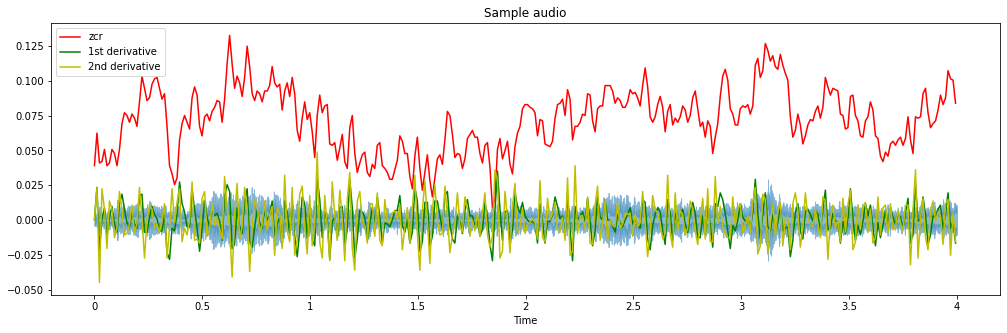

In [14]:
FRAME_LENGTH = 1024 #it gives 23,22 ms of audio duration what can be noticable by human, we also want the frame size to be
#the power of 2 for fft
HOP_LENGTH = 512 #the frames will overlap by the half of frame width

#getting the file name from dataset metadata
file_path = 'fold' + str(df.iloc[1]['fold']) + '/' + df.iloc[1]['slice_file_name']

#geting audio as samples list, the audio is converted to mono and resampled to 44100 if needed
y, sr = lb.load(file_path, mono=True, sr=44100)

#get zcr for our audio
zcr = librosa.feature.zero_crossing_rate(y=y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)[0]

if len(zcr)<2: zcr.append(0) # we need at least 2 elements to calculate delta_zcr
delta_zcr = [0]
delta_zcr.extend([zcr[i+1]-zcr[i] for i in range(len(zcr)-1)])
if len(delta_zcr)<2: delta_zcr.append(0) # we need at least 2 elements to calculate delta2_zcr
delta2_zcr = [0]
delta2_zcr.extend([delta_zcr[i+1]-delta_zcr[i] for i in range(len(delta_zcr)-1)])
if len(delta2_zcr)<2: delta2_zcr.append(0)  # we need at least 2 elements to avoid errors during calculating any statistics
                                            #for delta2_zcr

#set the time axis for zcr plots
frames = range(len(zcr))
t = lb.frames_to_time(frames, sr=sr, hop_length=HOP_LENGTH)
frames = range(len(delta_zcr))
t2 = lb.frames_to_time(frames, sr=sr, hop_length=HOP_LENGTH)
frames = range(len(delta2_zcr))
t3 = lb.frames_to_time(frames, sr=sr, hop_length=HOP_LENGTH)

#plot zcr curve
plt.figure(figsize=(17,5))
librosa.display.waveshow(y, sr=sr, alpha=0.5)
plt.plot(t, zcr, color='r', label='zcr')
plt.plot(t2, delta_zcr, color='g', label='1st derivative')
plt.plot(t3, delta2_zcr, color='y', label='2nd derivative')
plt.title('Sample audio')
plt.legend()

Let's write a function that will return some features extracted from zero crossing rate and it's derivatives.

In [15]:
def get_zcr_features(y, frame_l, hop_l):
    #get zcr for our audio
    zcr = librosa.feature.zero_crossing_rate(y=y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)[0]

    if len(zcr)<2: zcr.append(0) # we need at least 2 elements to calculate delta_zcr
    delta_zcr = [0] #1st element in derivative will be equal 0
    delta_zcr.extend([zcr[i+1]-zcr[i] for i in range(len(zcr)-1)])
    delta2_zcr = [0] #1st element in derivative will be equal 0
    delta2_zcr.extend([delta_zcr[i+1]-delta_zcr[i] for i in range(len(delta_zcr)-1)])
    
    features = {}
    prefixes = ['', 'delta_', 'delta2_']
    data = [zcr, delta_zcr, delta2_zcr]
    for i in range(3):
        features[prefixes[i]+'zcr_mean'] = np.mean(data[i])
        features[prefixes[i]+'zcr_median'] = np.median(data[i])
        features[prefixes[i]+'zcr_min'] = np.min(data[i])
        features[prefixes[i]+'zcr_max'] = np.max(data[i])
        features[prefixes[i]+'zcr_std'] = np.std(data[i])
        features[prefixes[i]+'zcr_skew'] = skew(data[i])
        features[prefixes[i]+'zcr_kurtosis'] = kurtosis(data[i])
    return features

# get_zcr_features(y, FRAME_LENGTH, HOP_LENGTH)

And new version of get_features' function..

In [16]:
def get_features(data_frame, features_type='all'):
    FRAME_LENGTH = 1024 #it gives 23,22 ms of audio duration what can be noticable by human, we also want the frame size to be
    #the power of 2 for fft
    HOP_LENGTH = 512 #the frames will overlap by the half of frame width
    
    classes = []
    
    for i in range(len(data_frame)):
        features = {}
        
        #getting the file name from dataset metadata
        file_path = 'fold' + str(data_frame.iloc[i]['fold']) + '/' + data_frame.iloc[i]['slice_file_name']

        #geting audio as samples list, the audio is converted to mono and resampled to 44100 if needed
        y, sr = lb.load(file_path, mono=True, sr=44100)
        
        #for the short audio we will append zeros to get 4 seconds audio
        y = np.concatenate((y, np.zeros(4*sr)))
        y = y[0:4*sr]           
        
        #rms_features
        if (features_type=='all') or (features_type=='rms'):
            feat = get_rms_features(y, FRAME_LENGTH, HOP_LENGTH)
            features = dict(features, **feat)
        
        #ae_features
        if (features_type=='all') or (features_type=='ae'):
            feat = get_ae_features(y, FRAME_LENGTH, HOP_LENGTH)
            features = dict(features, **feat)
        
        #zcr_features
        if (features_type=='all') or (features_type=='zcr'):
            feat = get_zcr_features(y, FRAME_LENGTH, HOP_LENGTH)
            features = dict(features, **feat)
        
        #here is a place for more features - to be continued
        #...
        #...
        
        temp = pd.DataFrame(data=features, index=[data_frame.index[i]]) #we need to keep original index value from meta-data file
        
        if i==0:
            X = temp
        else:
            X = pd.concat([X, temp])
            
        classes.append(data_frame.iloc[i]['class'])
        
    Y = pd.Series(classes, name='class', index=X.index)
    return X, Y

In [17]:
# extracting zcr features
# X_zcr, Y_zcr = get_features(df, 'zcr')

# save features to file
# with open('X_zcr.pickle', 'wb') as f:
#             pickle.dump(X_zcr, f)

# with open('Y_zcr.pickle', 'wb') as f:
#             pickle.dump(Y_zcr, f)

# load features from file
with open('X_zcr.pickle', 'rb') as f:
            X_zcr = pickle.load(f)

with open('Y_zcr.pickle', 'rb') as f:
            Y_zcr = pickle.load(f)

Let's check how will Randow Forest Classifier perform using this features - scaled and unscaled.

In [18]:
### create scaled features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# fit_transform() returns numpy.ndarray, if we want to keep indexes and column names, we do it like this
X_zcr_scaled = pd.DataFrame(scaler.fit_transform(X_zcr), index=X_zcr.index, columns=X_zcr.columns)

### spliting train and test data
train_X_zcr = X_zcr.loc[df['fold']!=10]
train_X_zcr_scaled = X_zcr_scaled.loc[df['fold']!=10]
train_Y_zcr = Y_zcr.loc[df['fold']!=10]
test_X_zcr = X_zcr.loc[df['fold']==10]
test_X_zcr_scaled = X_zcr_scaled.loc[df['fold']==10]
test_Y_zcr = Y_zcr.loc[df['fold']==10]

### create Random Forest classifier and evaluate it
rf_clf = RandomForestClassifier(n_jobs=-1, n_estimators=500, random_state=44)

# unscaled features
scores, _ = my_cross_val_using_9_folds(rf_clf, train_X_zcr, df2)
print('Random Forest average score - X unscaled: ', np.mean(scores))

# scaled features
scores, _ = my_cross_val_using_9_folds(rf_clf, train_X_zcr_scaled, df2)
print('Random Forest average score - X scaled: ', np.mean(scores))

Random Forest average score - X unscaled:  0.4367927284165528
Random Forest average score - X scaled:  0.43686178239605755


<h1> EXTRACTING FEATURES IN FREQUENCY DOMAIN</h1>

We will extract features from signal spectrum such as spectral centroid and spectral flatness. We will also compute average and skewness of spectral magnitude in defined frequency ranges.

<h2> Features extracted from spectral centroid in frequency domain </h2>
To extract features related to the spectral centroid we will use librosa library and the function librosa.feature.spectral_centroid()

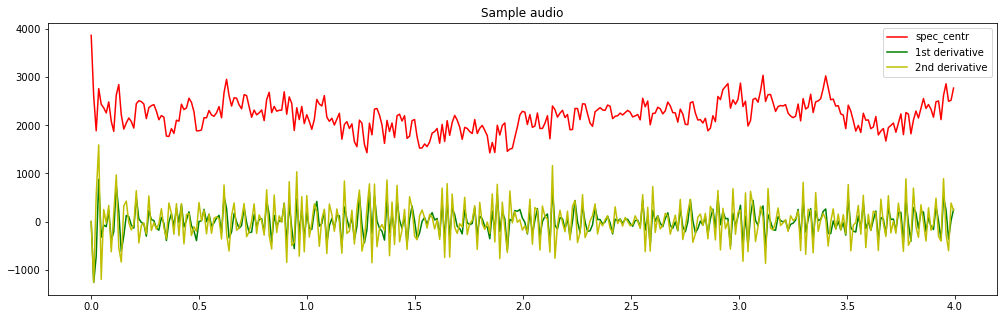

In [19]:
FRAME_LENGTH = 1024 #it gives 23,22 ms of audio duration what can be noticable by human, we also want the frame size to be
#the power of 2 for fft
HOP_LENGTH = 512 #the frames will overlap by the half of frame width

#getting the file name from dataset metadata
file_path = 'fold' + str(df.iloc[1]['fold']) + '/' + df.iloc[1]['slice_file_name']

#geting audio as samples list, the audio is converted to mono and resampled to 44100 if needed
y, sr = lb.load(file_path, mono=True, sr=44100)

#get spec_centr for our audio
spec_centr = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=1024, hop_length=512)[0]

if len(spec_centr)<2: spec_centr.append(0) # we need at least 2 elements to calculate delta_spec_centr
delta_spec_centr = [0]
delta_spec_centr.extend([spec_centr[i+1]-spec_centr[i] for i in range(len(spec_centr)-1)])
if len(delta_spec_centr)<2: delta_spec_centr.append(0) # we need at least 2 elements to calculate delta2_spec_centr
delta2_spec_centr = [0]
delta2_spec_centr.extend([delta_spec_centr[i+1]-delta_spec_centr[i] for i in range(len(delta_spec_centr)-1)])
if len(delta2_spec_centr)<2: delta2_spec_centr.append(0)  # we need at least 2 elements to avoid errors during calculating any statistics
                                            #for delta2_spec_centr

#set the time axis for spec_centr plots
frames = range(len(spec_centr))
t = lb.frames_to_time(frames, sr=sr, hop_length=HOP_LENGTH)
frames = range(len(delta_spec_centr))
t2 = lb.frames_to_time(frames, sr=sr, hop_length=HOP_LENGTH)
frames = range(len(delta2_spec_centr))
t3 = lb.frames_to_time(frames, sr=sr, hop_length=HOP_LENGTH)

#plot spec_centr curve
plt.figure(figsize=(17,5))
# librosa.display.waveshow(y, sr=sr, alpha=0.5)
plt.plot(t, spec_centr, color='r', label='spec_centr')
plt.plot(t2, delta_spec_centr, color='g', label='1st derivative')
plt.plot(t3, delta2_spec_centr, color='y', label='2nd derivative')
plt.title('Sample audio')
plt.legend()

Let's write a function that will extract some features from spectral centroid.

In [20]:
def get_spec_centr_features(y, frame_l, hop_l):
    #get spec_centr for our audio
    spec_centr = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=1024, hop_length=512)[0]

    if len(spec_centr)<2: spec_centr.append(0) # we need at least 2 elements to calculate delta_spec_centr
    delta_spec_centr = [0] #1st element in derivative will be equal 0
    delta_spec_centr.extend([spec_centr[i+1]-spec_centr[i] for i in range(len(spec_centr)-1)])
    delta2_spec_centr = [0] #1st element in derivative will be equal 0
    delta2_spec_centr.extend([delta_spec_centr[i+1]-delta_spec_centr[i] for i in range(len(delta_spec_centr)-1)])
    
    features = {}
    prefixes = ['', 'delta_', 'delta2_']
    data = [spec_centr, delta_spec_centr, delta2_spec_centr]
    for i in range(3):
        features[prefixes[i]+'spec_centr_mean'] = np.mean(data[i])
        features[prefixes[i]+'spec_centr_median'] = np.median(data[i])
        features[prefixes[i]+'spec_centr_min'] = np.min(data[i])
        features[prefixes[i]+'spec_centr_max'] = np.max(data[i])
        features[prefixes[i]+'spec_centr_std'] = np.std(data[i])
        features[prefixes[i]+'spec_centr_skew'] = skew(data[i])
        features[prefixes[i]+'spec_centr_kurtosis'] = kurtosis(data[i])
    return features

# get_spec_centr_features(y, FRAME_LENGTH, HOP_LENGTH)

And new version of get_features' function..

In [21]:
def get_features(data_frame, features_type='all'):
    FRAME_LENGTH = 1024 #it gives 23,22 ms of audio duration what can be noticable by human, we also want the frame size to be
    #the power of 2 for fft
    HOP_LENGTH = 512 #the frames will overlap by the half of frame width
    
    classes = []
    
    for i in range(len(data_frame)):
        features = {}
        
        #getting the file name from dataset metadata
        file_path = 'fold' + str(data_frame.iloc[i]['fold']) + '/' + data_frame.iloc[i]['slice_file_name']

        #geting audio as samples list, the audio is converted to mono and resampled to 44100 if needed
        y, sr = lb.load(file_path, mono=True, sr=44100)
        
        #for the short audio we will append zeros to get 4 seconds audio
        y = np.concatenate((y, np.zeros(4*sr)))
        y = y[0:4*sr]           
        
        #rms_features
        if (features_type=='all') or (features_type=='rms'):
            feat = get_rms_features(y, FRAME_LENGTH, HOP_LENGTH)
            features = dict(features, **feat)
        
        #ae_features
        if (features_type=='all') or (features_type=='ae'):
            feat = get_ae_features(y, FRAME_LENGTH, HOP_LENGTH)
            features = dict(features, **feat)
        
        #zcr_features
        if (features_type=='all') or (features_type=='zcr'):
            feat = get_zcr_features(y, FRAME_LENGTH, HOP_LENGTH)
            features = dict(features, **feat)
            
        #spec_centr features
        if (features_type=='all') or (features_type=='spec_centr'):
            feat = get_spec_centr_features(y, FRAME_LENGTH, HOP_LENGTH)
            features = dict(features, **feat)
        
        #here is a place for more features - to be continued
        #...
        #...
        
        temp = pd.DataFrame(data=features, index=[data_frame.index[i]]) #we need to keep original index value from meta-data file
        
        if i==0:
            X = temp
        else:
            X = pd.concat([X, temp])
            
        classes.append(data_frame.iloc[i]['class'])
        
    Y = pd.Series(classes, name='class', index=X.index)
    return X, Y

In [22]:
# extracting spec_centr features
# X_spec_centr, Y_spec_centr = get_features(df, 'spec_centr')

# save features to file
# with open('X_spec_centr.pickle', 'wb') as f:
#             pickle.dump(X_spec_centr, f)

# with open('Y_spec_centr.pickle', 'wb') as f:
#             pickle.dump(Y_spec_centr, f)

# load features from file
with open('X_spec_centr.pickle', 'rb') as f:
            X_spec_centr = pickle.load(f)

with open('Y_spec_centr.pickle', 'rb') as f:
            Y_spec_centr = pickle.load(f)

Again. Let's check how will Random Forest Classifier preform using this features - scaled and unscaled.


In [23]:
### create scaled features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# fit_transform() returns numpy.ndarray, if we want to keep indexes and column names, we do it like this
X_spec_centr_scaled = pd.DataFrame(scaler.fit_transform(X_spec_centr), index=X_spec_centr.index, columns=X_spec_centr.columns)

### spliting train and test data
train_X_spec_centr = X_spec_centr.loc[df['fold']!=10]
train_X_spec_centr_scaled = X_spec_centr_scaled.loc[df['fold']!=10]
train_Y_spec_centr = Y_spec_centr.loc[df['fold']!=10]
test_X_spec_centr = X_spec_centr.loc[df['fold']==10]
test_X_spec_centr_scaled = X_spec_centr_scaled.loc[df['fold']==10]
test_Y_spec_centr = Y_spec_centr.loc[df['fold']==10]

### create Random Forest classifier and evaluate it
rf_clf = RandomForestClassifier(n_jobs=-1, n_estimators=500, random_state=44)

# unscaled features
scores, _ = my_cross_val_using_9_folds(rf_clf, train_X_spec_centr, df2)
print('Random Forest average score - X unscaled: ', np.mean(scores))

# scaled features
scores, _ = my_cross_val_using_9_folds(rf_clf, train_X_spec_centr_scaled, df2)
print('Random Forest average score - X scaled: ', np.mean(scores))

Random Forest average score - X unscaled:  0.42417407921211553
Random Forest average score - X scaled:  0.4243454905450847


<h2> Features extracted from spectral flatness in frequency domain </h2>
To extract features related to the spectral flatness we will use librosa library and the function librosa.feature.spectral_flatness()

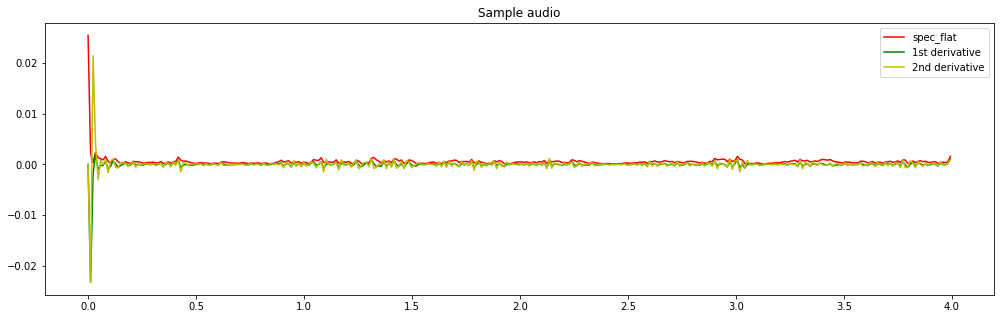

In [24]:
FRAME_LENGTH = 1024 #it gives 23,22 ms of audio duration what can be noticable by human, we also want the frame size to be
#the power of 2 for fft
HOP_LENGTH = 512 #the frames will overlap by the half of frame width

#getting the file name from dataset metadata
file_path = 'fold' + str(df.iloc[1]['fold']) + '/' + df.iloc[1]['slice_file_name']

#geting audio as samples list, the audio is converted to mono and resampled to 44100 if needed
y, sr = lb.load(file_path, mono=True, sr=44100)

#get spec_flat for our audio
spec_flat = librosa.feature.spectral_flatness(y=y, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH)[0]

if len(spec_flat)<2: spec_flat.append(0) # we need at least 2 elements to calculate delta_spec_flat
delta_spec_flat = [0]
delta_spec_flat.extend([spec_flat[i+1]-spec_flat[i] for i in range(len(spec_flat)-1)])
if len(delta_spec_flat)<2: delta_spec_flat.append(0) # we need at least 2 elements to calculate delta2_spec_flat
delta2_spec_flat = [0]
delta2_spec_flat.extend([delta_spec_flat[i+1]-delta_spec_flat[i] for i in range(len(delta_spec_flat)-1)])
if len(delta2_spec_flat)<2: delta2_spec_flat.append(0)  # we need at least 2 elements to avoid errors during calculating any statistics
                                            #for delta2_spec_flat

#set the time axis for spec_flat plots
frames = range(len(spec_flat))
t = lb.frames_to_time(frames, sr=sr, hop_length=HOP_LENGTH)
frames = range(len(delta_spec_flat))
t2 = lb.frames_to_time(frames, sr=sr, hop_length=HOP_LENGTH)
frames = range(len(delta2_spec_flat))
t3 = lb.frames_to_time(frames, sr=sr, hop_length=HOP_LENGTH)

#plot spec_flat curve
plt.figure(figsize=(17,5))
# librosa.display.waveshow(y, sr=sr, alpha=0.5)
plt.plot(t, spec_flat, color='r', label='spec_flat')
plt.plot(t2, delta_spec_flat, color='g', label='1st derivative')
plt.plot(t3, delta2_spec_flat, color='y', label='2nd derivative')
plt.title('Sample audio')
plt.legend()

And function for spectrum flatness features extraction.

In [25]:
def get_spec_flat_features(y, frame_l, hop_l):
    #get spec_flat for our audio
    spec_flat = librosa.feature.spectral_flatness(y=y, n_fft=frame_l, hop_length=hop_l)[0]

    if len(spec_flat)<2: spec_flat.append(0) # we need at least 2 elements to calculate delta_spec_flat
    delta_spec_flat = [0] #1st element in derivative will be equal 0
    delta_spec_flat.extend([spec_flat[i+1]-spec_flat[i] for i in range(len(spec_flat)-1)])
    delta2_spec_flat = [0] #1st element in derivative will be equal 0
    delta2_spec_flat.extend([delta_spec_flat[i+1]-delta_spec_flat[i] for i in range(len(delta_spec_flat)-1)])
    
    features = {}
    prefixes = ['', 'delta_', 'delta2_']
    data = [spec_flat, delta_spec_flat, delta2_spec_flat]
    for i in range(3):
        features[prefixes[i]+'spec_flat_mean'] = np.mean(data[i])
        features[prefixes[i]+'spec_flat_median'] = np.median(data[i])
        features[prefixes[i]+'spec_flat_min'] = np.min(data[i])
        features[prefixes[i]+'spec_flat_max'] = np.max(data[i])
        features[prefixes[i]+'spec_flat_std'] = np.std(data[i])
        features[prefixes[i]+'spec_flat_skew'] = skew(data[i])
        features[prefixes[i]+'spec_flat_kurtosis'] = kurtosis(data[i])
    return features

# get_spec_flat_features(y, FRAME_LENGTH, HOP_LENGTH)

In [26]:
def get_features(data_frame, features_type='all'):
    FRAME_LENGTH = 1024 #it gives 23,22 ms of audio duration what can be noticable by human, we also want the frame size to be
    #the power of 2 for fft
    HOP_LENGTH = 512 #the frames will overlap by the half of frame width
    
    classes = []
    
    for i in range(len(data_frame)):
        features = {}
        
        #getting the file name from dataset metadata
        file_path = 'fold' + str(data_frame.iloc[i]['fold']) + '/' + data_frame.iloc[i]['slice_file_name']

        #geting audio as samples list, the audio is converted to mono and resampled to 44100 if needed
        y, sr = lb.load(file_path, mono=True, sr=44100)
        
        #for the short audio we will append zeros to get 4 seconds audio
        y = np.concatenate((y, np.zeros(4*sr)))
        y = y[0:4*sr]           
        
        #rms_features
        if (features_type=='all') or (features_type=='rms'):
            feat = get_rms_features(y, FRAME_LENGTH, HOP_LENGTH)
            features = dict(features, **feat)
        
        #ae_features
        if (features_type=='all') or (features_type=='ae'):
            feat = get_ae_features(y, FRAME_LENGTH, HOP_LENGTH)
            features = dict(features, **feat)
        
        #zcr_features
        if (features_type=='all') or (features_type=='zcr'):
            feat = get_zcr_features(y, FRAME_LENGTH, HOP_LENGTH)
            features = dict(features, **feat)
            
        #spec_centr features
        if (features_type=='all') or (features_type=='spec_centr'):
            feat = get_spec_centr_features(y, FRAME_LENGTH, HOP_LENGTH)
            features = dict(features, **feat)
            
        #spec_flat features
        if (features_type=='all') or (features_type=='spec_flat'):
            feat = get_spec_flat_features(y, FRAME_LENGTH, HOP_LENGTH)
            features = dict(features, **feat)
        
        #here is a place for more features
        #...
        #...
        
        temp = pd.DataFrame(data=features, index=[data_frame.index[i]]) #we need to keep original index value from meta-data file
        
        if i==0:
            X = temp
        else:
            X = pd.concat([X, temp])
            
        classes.append(data_frame.iloc[i]['class'])
        
    Y = pd.Series(classes, name='class', index=X.index)
    return X, Y

In [27]:
# extracting spec_flat features
# X_spec_flat, Y_spec_flat = get_features(df, 'spec_flat')

# save features to file
# with open('X_spec_flat.pickle', 'wb') as f:
#             pickle.dump(X_spec_flat, f)

# with open('Y_spec_flat.pickle', 'wb') as f:
#             pickle.dump(Y_spec_flat, f)

# load features from file
with open('X_spec_flat.pickle', 'rb') as f:
            X_spec_flat = pickle.load(f)

with open('Y_spec_flat.pickle', 'rb') as f:
            Y_spec_flat = pickle.load(f)

In [28]:
### create scaled features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# fit_transform() returns numpy.ndarray, if we want to keep indexes and column names, we do it like this
X_spec_flat_scaled = pd.DataFrame(scaler.fit_transform(X_spec_flat), index=X_spec_flat.index, columns=X_spec_flat.columns)

### spliting train and test data
train_X_spec_flat = X_spec_flat.loc[df['fold']!=10]
train_X_spec_flat_scaled = X_spec_flat_scaled.loc[df['fold']!=10]
train_Y_spec_flat = Y_spec_flat.loc[df['fold']!=10]
test_X_spec_flat = X_spec_flat.loc[df['fold']==10]
test_X_spec_flat_scaled = X_spec_flat_scaled.loc[df['fold']==10]
test_Y_spec_flat = Y_spec_flat.loc[df['fold']==10]

### create Random Forest classifier and evaluate it
rf_clf = RandomForestClassifier(n_jobs=-1, n_estimators=500, random_state=44)

# unscaled features
scores, _ = my_cross_val_using_9_folds(rf_clf, train_X_spec_flat, df2)
print('Random Forest average score - X unscaled: ', np.mean(scores))

# scaled features
scores, _ = my_cross_val_using_9_folds(rf_clf, train_X_spec_flat_scaled, df2)
print('Random Forest average score - X scaled: ', np.mean(scores))

Random Forest average score - X unscaled:  0.34434356757756684
Random Forest average score - X scaled:  0.34534481145519613


Now let's extract all our new features at ones. Then we will add features extracted in part 1 and check how will our models perfom on extended features.

In [29]:
# extracting spec_flat features
# X, Y = get_features(df)

# save features to file
# with open('part3_X.pickle', 'wb') as f:
#             pickle.dump(X, f)

# with open('part3_Y.pickle', 'wb') as f:
#             pickle.dump(Y, f)

# load features from file
with open('part3_X.pickle', 'rb') as f:
            X = pickle.load(f)

with open('part3_Y.pickle', 'rb') as f:
            Y = pickle.load(f)

In [30]:
X.shape

(8732, 105)

In [31]:
X_all = pd.concat([X, X_mfcc], axis=1)
X_all.shape

(8732, 380)

We have 380 features. It is significantly more then just mfcc features which we have 275. Now we will check how our top 5 models perform using all 380 features. Then we will reduce the number of features and also check the performance of our models.</br>

We will use 9 folds cross validation, and check scaled and unscaled features.

In [32]:
# separate train data
train_X_all = X_all.loc[df['fold']!=10]
train_Y = df.loc[df['fold']!=10]['class']
test_X_all = X_all.loc[df['fold']==10]
test_Y = df.loc[df['fold']==10]['class']

# standardize features, we fit scaler only with train data, test data is being trasformed with scaler fitted with train data
train_X_all_scaled = pd.DataFrame(scaler.fit_transform(train_X_all), index=train_X_all.index, columns=train_X_all.columns)
test_X_all_scaled = pd.DataFrame(scaler.transform(test_X_all), index=test_X_all.index, columns=test_X_all.columns)

# create dicts to save scores
score_table_all_features_unscaled = {}
score_table_all_features_scaled = {}

Logistic Regression Classifier

In [33]:
### create Logistic Regression classifier and evaluate it
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression(random_state=44)

# unscaled features
lr_clf.fit(train_X_all, train_Y)
Y_pred = lr_clf.predict(test_X_all)
score = np.sum(Y_pred == test_Y)/len(test_Y)
score_table_all_features_unscaled['Logistic Regression'] = score
print('Logistic Regression average score - X unscaled: ', score)

# scaled features
lr_clf.fit(train_X_all_scaled, train_Y)
Y_pred = lr_clf.predict(test_X_all_scaled)
score = np.sum(Y_pred == test_Y)/len(test_Y)
score_table_all_features_scaled['Logistic Regression'] = score
print('Logistic Regression average score - X scaled: ', score)

Logistic Regression average score - X unscaled:  0.5734767025089605
Logistic Regression average score - X scaled:  0.7013142174432497


Ridge Classifier

In [34]:
### create Ridge classifier and evaluate it
from sklearn.linear_model import RidgeClassifier
ridge_clf = RidgeClassifier(random_state=44)

# unscaled features
ridge_clf.fit(train_X_all, train_Y)
Y_pred = ridge_clf.predict(test_X_all)
score = np.sum(Y_pred == test_Y)/len(test_Y)
score_table_all_features_unscaled['Ridge'] = score
print('Ridge average score - X unscaled: ', score)

# scaled features
ridge_clf.fit(train_X_all_scaled, train_Y)
Y_pred = ridge_clf.predict(test_X_all_scaled)
score = np.sum(Y_pred == test_Y)/len(test_Y)
score_table_all_features_scaled['Ridge'] = score
print('Ridge average score - X scaled: ', score)

Ridge average score - X unscaled:  0.6905615292712067
Ridge average score - X scaled:  0.6917562724014337


Multi-Layer Perceptron Classifier

In [35]:
### create Multi-Layer Perceptron classifier and evaluate it
from sklearn.neural_network import MLPClassifier
mlp_clf = MLPClassifier(random_state=44)

# unscaled features
mlp_clf.fit(train_X_all, train_Y)
Y_pred = mlp_clf.predict(test_X_all)
score = np.sum(Y_pred == test_Y)/len(test_Y)
score_table_all_features_unscaled['MLP'] = score
print('MLP average score - X unscaled: ', score)

# scaled features
mlp_clf.fit(train_X_all_scaled, train_Y)
Y_pred = mlp_clf.predict(test_X_all_scaled)
score = np.sum(Y_pred == test_Y)/len(test_Y)
score_table_all_features_scaled['MLP'] = score
print('MLP average score - X scaled: ', score)

MLP average score - X unscaled:  0.6965352449223416
MLP average score - X scaled:  0.7443249701314217


Random Forest Classifier

In [36]:
### create Random Forest classifier and evaluate it
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_jobs=-1, n_estimators=500, random_state=44)

# unscaled features
rf_clf.fit(train_X_all, train_Y)
Y_pred = rf_clf.predict(test_X_all)
score = np.sum(Y_pred == test_Y)/len(test_Y)
score_table_all_features_unscaled['Random Forest'] = score
print('Random Forest average score - X unscaled: ', score)

# scaled features
rf_clf.fit(train_X_all_scaled, train_Y)
Y_pred = rf_clf.predict(test_X_all_scaled)
score = np.sum(Y_pred == test_Y)/len(test_Y)
score_table_all_features_scaled['Random Forest'] = score
print('Random Forest average score - X scaled: ', score)

Random Forest average score - X unscaled:  0.7514934289127837
Random Forest average score - X scaled:  0.7491039426523297


Support Vector Machines Classifier

In [37]:
### create Support Vector Machines classifier and evaluate it
from sklearn.svm import SVC
svc_clf = SVC(random_state=44)

# unscaled features
svc_clf.fit(train_X_all, train_Y)
Y_pred = svc_clf.predict(test_X_all)
score = np.sum(Y_pred == test_Y)/len(test_Y)
score_table_all_features_unscaled['SVM'] = score
print('SVM average score - X unscaled: ', score)

# scaled features
svc_clf.fit(train_X_all_scaled, train_Y)
Y_pred = svc_clf.predict(test_X_all_scaled)
score = np.sum(Y_pred == test_Y)/len(test_Y)
score_table_all_features_scaled['SVM'] = score
print('SVM average score - X scaled: ', score)

SVM average score - X unscaled:  0.4994026284348865
SVM average score - X scaled:  0.7765830346475507


Let's update our score table and compare results.

In [38]:
score_table = pd.read_csv('part2_score_table.csv', index_col=0)
score_table.drop(['MAX'], axis=1, inplace=True)
score_table = pd.concat([score_table,
                         pd.Series(score_table_all_features_unscaled, name='all'),
                         pd.Series(score_table_all_features_scaled, name='all_scaled'),],
                        axis=1)

score_table['MAX'] = score_table.max(axis=1)
score_table.sort_values(by='MAX', ascending=False)

,base_X_unscaled,base_X_scaled,all,all_scaled,MAX
SVM,0.372760,0.770609,0.499403,0.776583,0.776583
Random Forest,0.757467,0.756272,0.751493,0.749104,0.757467
MLP,0.654719,0.735962,0.696535,0.744325,0.744325
Logistic Regression,0.565114,0.695341,0.573477,0.701314,0.701314
Ridge,0.688172,0.682198,0.690562,0.691756,0.691756
Passive Agressive,0.523297,0.666667,NaN,NaN,0.666667
SGD,0.486260,0.598566,NaN,NaN,0.598566
KNN,0.524492,0.577061,NaN,NaN,0.577061
Nearest Centroid,0.285544,0.505376,NaN,NaN,0.505376
Decision Tree,0.500597,0.500597,NaN,NaN,0.500597


In most cases adding new features improved models performance. We need to notice that those results are achived by models with default hyperparameters. Tuning models can result in father improvement.

Now we will reduce number of features in three defferent ways.</br>
The first way is feature reduction by iterative elimination of the least important feature. Starting from all 380 features and at the end we will keep only 250 features. That is even less then the number of mfccs features. We will write a function that will eliminate features one by one depending on RandomForest parameters 'feature_importances'. It also prints the name of reduced feature and its rate/importance.

In [39]:
def iterative_features_elimination(X, df, clf, max_features):
    X2 = X.copy()
    while len(X2.columns)>max_features:
        clf.fit(X2, df['class'])
        feature_importances = clf.feature_importances_
        ranking = sorted(zip(feature_importances, X2.columns), reverse=True)
        feat_to_drop = ranking[-1][1]
        print(ranking[-1])
        X2.drop(columns=[feat_to_drop], inplace=True)
    return X2

To point the least important features we will use only train set.

In [40]:
# train_X_reduced = iterative_features_elimination(train_X_all, df2, rf_clf, 250)

# save features to file
# with open('part3_train_X_reduced.pickle', 'wb') as f:
#             pickle.dump(train_X_reduced, f)

# load features from file
with open('part3_train_X_reduced.pickle', 'rb') as f:
            train_X_reduced = pickle.load(f)

In [41]:
train_X_reduced.shape

(7895, 250)

Looking at eliminated features we can see that many of mfcc features were rated as less important then many features extracted from signal energii, amplitude, etc.</br>
Let's check how our models perfom using selected features.

In [42]:
# selecting reduced scaled train set and scaled and unscaled test set from all features test set
train_X_reduced_scaled = train_X_all_scaled[train_X_reduced.columns]
test_X_reduced = test_X_all[train_X_reduced.columns]
test_X_reduced_scaled = test_X_all_scaled[train_X_reduced.columns]

# dictionaries to save models scores
score_table_reduced_features_unscaled = {}
score_table_reduced_features_scaled = {}

Logistic Regression Classifier

In [43]:
### create Logistic Regression classifier and evaluate it
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression(random_state=44)

# unscaled features
lr_clf.fit(train_X_reduced, train_Y)
Y_pred = lr_clf.predict(test_X_reduced)
score = np.sum(Y_pred == test_Y)/len(test_Y)
score_table_reduced_features_unscaled['Logistic Regression'] = score
print('Logistic Regression average score - X unscaled: ', score)

# scaled features
lr_clf.fit(train_X_reduced_scaled, train_Y)
Y_pred = lr_clf.predict(test_X_reduced_scaled)
score = np.sum(Y_pred == test_Y)/len(test_Y)
score_table_reduced_features_scaled['Logistic Regression'] = score
print('Logistic Regression average score - X scaled: ', score)

Logistic Regression average score - X unscaled:  0.5878136200716846
Logistic Regression average score - X scaled:  0.7359617682198327


Ridge Classifier

In [44]:
### create Ridge classifier and evaluate it
from sklearn.linear_model import RidgeClassifier
ridge_clf = RidgeClassifier(random_state=44)

# unscaled features
ridge_clf.fit(train_X_reduced, train_Y)
Y_pred = ridge_clf.predict(test_X_reduced)
score = np.sum(Y_pred == test_Y)/len(test_Y)
score_table_reduced_features_unscaled['Ridge'] = score
print('Ridge average score - X unscaled: ', score)

# scaled features
ridge_clf.fit(train_X_reduced_scaled, train_Y)
Y_pred = ridge_clf.predict(test_X_reduced_scaled)
score = np.sum(Y_pred == test_Y)/len(test_Y)
score_table_reduced_features_scaled['Ridge'] = score
print('Ridge average score - X scaled: ', score)

Ridge average score - X unscaled:  0.6989247311827957
Ridge average score - X scaled:  0.7060931899641577


Multi-Layer Perceptron Classifier

In [45]:
### create Multi-Layer Perceptron classifier and evaluate it
from sklearn.neural_network import MLPClassifier
mlp_clf = MLPClassifier(random_state=44)

# unscaled features
mlp_clf.fit(train_X_reduced, train_Y)
Y_pred = mlp_clf.predict(test_X_reduced)
score = np.sum(Y_pred == test_Y)/len(test_Y)
score_table_reduced_features_unscaled['MLP'] = score
print('MLP average score - X unscaled: ', score)

# scaled features
mlp_clf.fit(train_X_reduced_scaled, train_Y)
Y_pred = mlp_clf.predict(test_X_reduced_scaled)
score = np.sum(Y_pred == test_Y)/len(test_Y)
score_table_reduced_features_scaled['MLP'] = score
print('MLP average score - X scaled: ', score)

MLP average score - X unscaled:  0.6821983273596177
MLP average score - X scaled:  0.7610513739545998


Random Forest Classifier

In [46]:
### create Random Forest classifier and evaluate it
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_jobs=-1, n_estimators=500, random_state=44)

# unscaled features
rf_clf.fit(train_X_reduced, train_Y)
Y_pred = rf_clf.predict(test_X_reduced)
score = np.sum(Y_pred == test_Y)/len(test_Y)
score_table_reduced_features_unscaled['Random Forest'] = score
print('Random Forest average score - X unscaled: ', score)

# scaled features
rf_clf.fit(train_X_reduced_scaled, train_Y)
Y_pred = rf_clf.predict(test_X_reduced_scaled)
score = np.sum(Y_pred == test_Y)/len(test_Y)
score_table_reduced_features_scaled['Random Forest'] = score
print('Random Forest average score - X scaled: ', score)

Random Forest average score - X unscaled:  0.7586618876941458
Random Forest average score - X scaled:  0.7610513739545998


Support Vector Machines Classifier

In [47]:
### create Support Vector Machines classifier and evaluate it
from sklearn.svm import SVC
svc_clf = SVC(random_state=44)

# unscaled features
svc_clf.fit(train_X_reduced, train_Y)
Y_pred = svc_clf.predict(test_X_reduced)
score = np.sum(Y_pred == test_Y)/len(test_Y)
score_table_reduced_features_unscaled['SVM'] = score
print('SVM average score - X unscaled: ', score)

# scaled features
svc_clf.fit(train_X_reduced_scaled, train_Y)
Y_pred = svc_clf.predict(test_X_reduced_scaled)
score = np.sum(Y_pred == test_Y)/len(test_Y)
score_table_reduced_features_scaled['SVM'] = score
print('SVM average score - X scaled: ', score)

SVM average score - X unscaled:  0.4886499402628435
SVM average score - X scaled:  0.7813620071684588


Let's try some other method of features reduction - variance threshold.</br>
It removes all features which variance doesn't meet some threshold. By default, it removes all zero-variance features, i.e., features that have the same value in all samples.

In [48]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
train_X_reduced2_array = sel.fit_transform(train_X_all)

# we need to get index and columns names back
cols = sel.get_feature_names_out(train_X_all.columns)
train_X_reduced2 = pd.DataFrame(train_X_reduced2_array, index = train_X_all.index, columns = cols)

In [49]:
# selecting reduced scaled test set from all features test set
train_X_reduced2_scaled = train_X_all_scaled[train_X_reduced2.columns]
test_X_reduced2 = test_X_all[train_X_reduced2.columns]
test_X_reduced2_scaled = test_X_all_scaled[train_X_reduced2.columns]

# dictionaries to save models scores
score_table_reduced2_features_unscaled = {}
score_table_reduced2_features_scaled = {}

Logistic Regressionn Classifier

In [50]:
### create Logistic Regression classifier and evaluate it
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression(random_state=44)

# unscaled features
lr_clf.fit(train_X_reduced2, train_Y)
Y_pred = lr_clf.predict(test_X_reduced2)
score = np.sum(Y_pred == test_Y)/len(test_Y)
score_table_reduced2_features_unscaled['Logistic Regression'] = score
print('Logistic Regression average score - X unscaled: ', score)

# scaled features
lr_clf.fit(train_X_reduced2_scaled, train_Y)
Y_pred = lr_clf.predict(test_X_reduced2_scaled)
score = np.sum(Y_pred == test_Y)/len(test_Y)
score_table_reduced2_features_scaled['Logistic Regression'] = score
print('Logistic Regression average score - X scaled: ', score)

Logistic Regression average score - X unscaled:  0.5722819593787336
Logistic Regression average score - X scaled:  0.7287933094384708


Ridge Classifier

In [51]:
### create Ridge classifier and evaluate it
from sklearn.linear_model import RidgeClassifier
ridge_clf = RidgeClassifier(random_state=44)

# unscaled features
ridge_clf.fit(train_X_reduced2, train_Y)
Y_pred = ridge_clf.predict(test_X_reduced2)
score = np.sum(Y_pred == test_Y)/len(test_Y)
score_table_reduced2_features_unscaled['Ridge'] = score
print('Ridge average score - X unscaled: ', score)

# scaled features
ridge_clf.fit(train_X_reduced2_scaled, train_Y)
Y_pred = ridge_clf.predict(test_X_reduced2_scaled)
score = np.sum(Y_pred == test_Y)/len(test_Y)
score_table_reduced2_features_scaled['Ridge'] = score
print('Ridge average score - X scaled: ', score)

Ridge average score - X unscaled:  0.6798088410991637
Ridge average score - X scaled:  0.6821983273596177


Multi-Layer Perceptron

In [52]:
### create Multi-Layer Perceptron classifier and evaluate it
from sklearn.neural_network import MLPClassifier
mlp_clf = MLPClassifier(random_state=44)

# unscaled features
mlp_clf.fit(train_X_reduced2, train_Y)
Y_pred = mlp_clf.predict(test_X_reduced2)
score = np.sum(Y_pred == test_Y)/len(test_Y)
score_table_reduced2_features_unscaled['MLP'] = score
print('MLP average score - X unscaled: ', score)

# scaled features
mlp_clf.fit(train_X_reduced2_scaled, train_Y)
Y_pred = mlp_clf.predict(test_X_reduced2_scaled)
score = np.sum(Y_pred == test_Y)/len(test_Y)
score_table_reduced2_features_scaled['MLP'] = score
print('MLP average score - X scaled: ', score)

MLP average score - X unscaled:  0.6451612903225806
MLP average score - X scaled:  0.7574671445639187


Random Forest Classifier

In [53]:
### create Random Forest classifier and evaluate it
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_jobs=-1, n_estimators=500, random_state=44)

# unscaled features
rf_clf.fit(train_X_reduced2, train_Y)
Y_pred = rf_clf.predict(test_X_reduced2)
score = np.sum(Y_pred == test_Y)/len(test_Y)
score_table_reduced2_features_unscaled['Random Forest'] = score
print('Random Forest average score - X unscaled: ', score)

# scaled features
rf_clf.fit(train_X_reduced2_scaled, train_Y)
Y_pred = rf_clf.predict(test_X_reduced2_scaled)
score = np.sum(Y_pred == test_Y)/len(test_Y)
score_table_reduced2_features_scaled['Random Forest'] = score
print('Random Forest average score - X scaled: ', score)

Random Forest average score - X unscaled:  0.7706093189964157
Random Forest average score - X scaled:  0.7694145758661888


Support Vector Machines

In [54]:
### create Support Vector Machines classifier and evaluate it
from sklearn.svm import SVC
svc_clf = SVC(random_state=44)

# unscaled features
svc_clf.fit(train_X_reduced2, train_Y)
Y_pred = svc_clf.predict(test_X_reduced2)
score = np.sum(Y_pred == test_Y)/len(test_Y)
score_table_reduced2_features_unscaled['SVM'] = score
print('SVM average score - X unscaled: ', score)

# scaled features
svc_clf.fit(train_X_reduced2_scaled, train_Y)
Y_pred = svc_clf.predict(test_X_reduced2_scaled)
score = np.sum(Y_pred == test_Y)/len(test_Y)
score_table_reduced2_features_scaled['SVM'] = score
print('SVM average score - X scaled: ', score)

SVM average score - X unscaled:  0.4994026284348865
SVM average score - X scaled:  0.7682198327359617


The last method we want to try is L1-based features selection</br>
When we use L1 penalty in linear models the features that are less important get coefficient 0. We will use linearSVC model and SelectFromModel class from scikit-learn library.
By changing the C parameter of the model we can adjust the number of selected features. The smaller C the fewer features selected.

In [55]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(train_X_all, train_Y)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(train_X_all)
cols = model.get_feature_names_out(train_X_all.columns)
train_X_reduced3 = pd.DataFrame(X_new, index=train_X_all.index, columns=cols)
train_X_reduced3.shape

(7895, 250)

In [56]:
# selecting reduced scaled test set from all features test set
train_X_reduced3_scaled = train_X_all_scaled[train_X_reduced3.columns]
test_X_reduced3 = test_X_all[train_X_reduced3.columns]
test_X_reduced3_scaled = test_X_all_scaled[train_X_reduced3.columns]

# dictionaries to save models scores
score_table_reduced3_features_unscaled = {}
score_table_reduced3_features_scaled = {}

Logistic Regression Classifier

In [57]:
### create Logistic Regression classifier and evaluate it
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression(random_state=44)

# unscaled features
lr_clf.fit(train_X_reduced3, train_Y)
Y_pred = lr_clf.predict(test_X_reduced3)
score = np.sum(Y_pred == test_Y)/len(test_Y)
score_table_reduced3_features_unscaled['Logistic Regression'] = score
print('Logistic Regression average score - X unscaled: ', score)

# scaled features
lr_clf.fit(train_X_reduced3_scaled, train_Y)
Y_pred = lr_clf.predict(test_X_reduced3_scaled)
score = np.sum(Y_pred == test_Y)/len(test_Y)
score_table_reduced3_features_scaled['Logistic Regression'] = score
print('Logistic Regression average score - X scaled: ', score)

Logistic Regression average score - X unscaled:  0.5698924731182796
Logistic Regression average score - X scaled:  0.7479091995221028


Ridge Classifier

In [58]:
### create Ridge classifier and evaluate it
from sklearn.linear_model import RidgeClassifier
ridge_clf = RidgeClassifier(random_state=44)

# unscaled features
ridge_clf.fit(train_X_reduced3, train_Y)
Y_pred = ridge_clf.predict(test_X_reduced3)
score = np.sum(Y_pred == test_Y)/len(test_Y)
score_table_reduced3_features_unscaled['Ridge'] = score
print('Ridge average score - X unscaled: ', score)

# scaled features
ridge_clf.fit(train_X_reduced3_scaled, train_Y)
Y_pred = ridge_clf.predict(test_X_reduced3_scaled)
score = np.sum(Y_pred == test_Y)/len(test_Y)
score_table_reduced3_features_scaled['Ridge'] = score
print('Ridge average score - X scaled: ', score)

Ridge average score - X unscaled:  0.6750298685782556
Ridge average score - X scaled:  0.6738351254480287


Multi-Layer Perceptron

In [59]:
### create Multi-Layer Perceptron classifier and evaluate it
from sklearn.neural_network import MLPClassifier
mlp_clf = MLPClassifier(random_state=44)

# unscaled features
mlp_clf.fit(train_X_reduced3, train_Y)
Y_pred = mlp_clf.predict(test_X_reduced3)
score = np.sum(Y_pred == test_Y)/len(test_Y)
score_table_reduced3_features_unscaled['MLP'] = score
print('MLP average score - X unscaled: ', score)

# scaled features
mlp_clf.fit(train_X_reduced3_scaled, train_Y)
Y_pred = mlp_clf.predict(test_X_reduced3_scaled)
score = np.sum(Y_pred == test_Y)/len(test_Y)
score_table_reduced3_features_scaled['MLP'] = score
print('MLP average score - X scaled: ', score)

MLP average score - X unscaled:  0.6523297491039427
MLP average score - X scaled:  0.7395459976105138


Random Forest Classifier

In [60]:
### create Random Forest classifier and evaluate it
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_jobs=-1, n_estimators=500, random_state=44)

# unscaled features
rf_clf.fit(train_X_reduced3, train_Y)
Y_pred = rf_clf.predict(test_X_reduced3)
score = np.sum(Y_pred == test_Y)/len(test_Y)
score_table_reduced3_features_unscaled['Random Forest'] = score
print('Random Forest average score - X unscaled: ', score)

# scaled features
rf_clf.fit(train_X_reduced3_scaled, train_Y)
Y_pred = rf_clf.predict(test_X_reduced3_scaled)
score = np.sum(Y_pred == test_Y)/len(test_Y)
score_table_reduced3_features_scaled['Random Forest'] = score
print('Random Forest average score - X scaled: ', score)

Random Forest average score - X unscaled:  0.7694145758661888
Random Forest average score - X scaled:  0.7694145758661888


Support Vector Machines Classifier

In [61]:
### create Support Vector Machines classifier and evaluate it
from sklearn.svm import SVC
svc_clf = SVC(random_state=44)

# unscaled features
svc_clf.fit(train_X_reduced3, train_Y)
Y_pred = svc_clf.predict(test_X_reduced3)
score = np.sum(Y_pred == test_Y)/len(test_Y)
score_table_reduced3_features_unscaled['SVM'] = score
print('SVM average score - X unscaled: ', score)

# scaled features
svc_clf.fit(train_X_reduced3_scaled, train_Y)
Y_pred = svc_clf.predict(test_X_reduced3_scaled)
score = np.sum(Y_pred == test_Y)/len(test_Y)
score_table_reduced3_features_scaled['SVM'] = score
print('SVM average score - X scaled: ', score)

SVM average score - X unscaled:  0.4994026284348865
SVM average score - X scaled:  0.7646356033452808


Let's print our score table.

In [62]:
# read score table from part2
score_table = pd.read_csv('part2_score_table.csv', index_col=0)

# drop 'max' column
score_table.drop(['MAX'], axis=1, inplace=True)

# make new DataFrame using new  results
score_table = pd.concat([score_table,
                         pd.Series(score_table_all_features_unscaled, name='all'),
                         pd.Series(score_table_all_features_scaled, name='all_scaled'),
                         pd.Series(score_table_reduced_features_unscaled, name='reduced'),
                         pd.Series(score_table_reduced_features_scaled, name='reduced_scaled'),
                         pd.Series(score_table_reduced2_features_unscaled, name='reduced2'),
                         pd.Series(score_table_reduced2_features_scaled, name='reduced2_scaled'),
                         pd.Series(score_table_reduced3_features_unscaled, name='reduced3'),
                         pd.Series(score_table_reduced3_features_scaled, name='reduced3_scaled')],
                        axis=1)

# add new column with best result for each model
score_table['MAX'] = score_table.max(axis=1)

# save to file
score_table.to_csv('part3_score_table.csv')

# show sorted score table
temp = score_table.sort_values(by='MAX', ascending=False)

def highlight_max(s, props=''):
    return np.where(s == np.max(s.values), props, '')

temp.style.apply(highlight_max, props='color:white;background-color:green', axis=1)

,base_X_unscaled,base_X_scaled,all,all_scaled,reduced,reduced_scaled,reduced2,reduced2_scaled,reduced3,reduced3_scaled,MAX
SVM,0.372760,0.770609,0.499403,0.776583,0.488650,0.781362,0.499403,0.768220,0.499403,0.764636,0.781362
Random Forest,0.757467,0.756272,0.751493,0.749104,0.758662,0.761051,0.770609,0.769415,0.769415,0.769415,0.770609
MLP,0.654719,0.735962,0.696535,0.744325,0.682198,0.761051,0.645161,0.757467,0.652330,0.739546,0.761051
Logistic Regression,0.565114,0.695341,0.573477,0.701314,0.587814,0.735962,0.572282,0.728793,0.569892,0.747909,0.747909
Ridge,0.688172,0.682198,0.690562,0.691756,0.698925,0.706093,0.679809,0.682198,0.675030,0.673835,0.706093
Passive Agressive,0.523297,0.666667,nan,nan,nan,nan,nan,nan,nan,nan,0.666667
SGD,0.486260,0.598566,nan,nan,nan,nan,nan,nan,nan,nan,0.598566
KNN,0.524492,0.577061,nan,nan,nan,nan,nan,nan,nan,nan,0.577061
Nearest Centroid,0.285544,0.505376,nan,nan,nan,nan,nan,nan,nan,nan,0.505376
Decision Tree,0.500597,0.500597,nan,nan,nan,nan,nan,nan,nan,nan,0.500597


As we can see after reducing features number the results are better in all cases.</br>
One reason for that is that when we have relatively many features and little samples, models minimize loss functions finding some patterns in trainig set (fit to training set) and that patterns/rules are not "true" in general, so when we show test set to such trained model it will not performe very good.
Another reason for that can be that linear models do not perform very well when features are correlated. It can be that many of added features were correlated one to each other. Reducing number of correlated feature can result in better model performance.</br>
Next reason can be that models were not tuned. By tunning models (for example to apply some regularization) we make them work better with the features that are given.</br>
Let's try to tune SVM model for 'all' features and for 'reduced' features.

Our functions for model tuning.

In [63]:
# create our cross_val function
def my_cross_val_using_9_folds(clf, X, data):
    test_score = []
    train_score = []
    if len(X.index) != len(data.index):
        print("Indexes of X and data are not the same length!!!")
        return test_score, train_score
    if (X.index != data.index).any():
        print("Indexes of X and data are not equal!!!")
        return test_score, train_score
    for i in range(1,10):
        X_train = X.loc[data['fold']!=i]
        Y_train = data.loc[data['fold']!=i]['class']
        X_test = X.loc[data['fold']==i]
        Y_test = data.loc[data['fold']==i]['class']
        clf.fit(X_train, Y_train)
        Y_pred = clf.predict(X_test)
        temp = np.sum(Y_pred==Y_test)/len(Y_test)
        test_score.append(temp)
        Y_pred = clf.predict(X_train)
        temp = np.sum(Y_pred==Y_train)/len(Y_train)
        train_score.append(temp)
    return test_score, train_score

# this function rewrite given list of dictionaries generating new list which elements are all possibe combinations of
# element in given list and elements in arg 'value' which is also a list
def add_param(name, values, my_list=[]):
    new_list = []
    if len(my_list)==0:
        my_list.append({})
    for l in my_list:
        for value in values:
            temp_my_dict = l.copy()
            temp_my_dict[name]=value
            new_list.append(temp_my_dict)
    return new_list

# this function generate all possible combinations of parameters given in arg params, arg params is a list of dictionaries
# accorging to the approach taken in sklearn library class GridSearchCV
def make_list_of_parameters_dictionary(params):
    list_of_parameters = []
    for d in params:
        item_list = []
        for name, values in d.items():
            item_list = add_param(name, values, item_list)
        list_of_parameters.extend(item_list)
    return list_of_parameters
    
from os.path import exists

# our grid search function generates all possible combinations of parameters given in 'params' and performs cross validation
# for given classifier setted with each parameters combination, returning best set of parameters accorging to 'accuracy' metrics
# return set of parameters is a full set of model's parameters
def my_grid_search_cross_validation(clf, X, df, params):
    best_score = 0
    best_params = {}
    start = time.time()
    i = 1
    list_of_parameters = make_list_of_parameters_dictionary(params)
    l = len(list_of_parameters)
    df2 = df.loc[df['fold']!=10]
    for p in list_of_parameters:
        clf.set_params(**p)
        test_score, train_score = my_cross_val_using_9_folds(clf, X, df2)
        mean_test_score = np.mean(test_score)
        mean_train_score = np.mean(train_score)
        if mean_test_score > best_score:
            best_params = clf.get_params()
            best_score = mean_test_score
        print('\n',i,'/',l,' duration: ',time.time()-start, ' best score: ',best_score)
        print('Test score:    ', mean_test_score)
        print('Train score:   ', mean_train_score)
        print(p)
        i += 1
        if exists('stop.txt'):
            print('Proces przerwany.')
            break
    print('Best score: ', best_score)
    print('Best params: ', best_params)
    return best_params

Tuning SVM against all features.

In [64]:
param_grid = [
    {
        'C': [1.9], #[x/10 for x in range(16,25)] #1.6, 2, 2.5, 3, 4, 5]
        'kernel': ['rbf'], #['linear', 'poly', 'rbf', 'sigmoid']
        'gamma': ['auto'],
        'tol': [1e-5], #, 1e-4], #, 1e-3, 1e-2],
        'class_weight': [None], #, 'balanced'],
        'max_iter': [-1], #, 100, 500, 1000, 2000, 5000],
        'decision_function_shape': ['ovo', 'ovr'],
    }]

# parameters that we are sure will be defined here and set model with them before starting the grid search process
constant_params = {'random_state': 44}

In [65]:
svc_clf.set_params(**constant_params)
# svc_best_params_all_features = my_grid_search_cross_validation(svc_clf, train_X_all_scaled, df, param_grid)

SVC(random_state=44)

In [66]:
svc_best_params_all_features = {'C': 1.9, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0,
                                'decision_function_shape': 'ovo', 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf',
                                'max_iter': -1, 'probability': False, 'random_state': 44, 'shrinking': True,
                                'tol': 1e-05, 'verbose': False}

In [67]:
svc_clf.set_params(**svc_best_params_all_features)

svc_clf.fit(train_X_all_scaled, train_Y)
Y_pred = svc_clf.predict(test_X_all_scaled)
score = np.sum(Y_pred == test_Y)/len(test_Y)
print('SVM average score - X scaled: ', score)

SVM average score - X scaled:  0.7801672640382318


The score is better then before tuning but it is worse then score of not tuned model with reduced features.</br>
Let's tune the model against reduced features.

In [68]:
param_grid = [
    {
        'C': [1.5, 1.6, 1.7], #1.6, 2, 2.5, 3, 4, 5]
        'kernel': ['rbf'], #['linear', 'poly', 'rbf', 'sigmoid'],
        'gamma': ['auto'],
        'tol': [1e-3],
        'class_weight': [None], #, 'balanced'],
        'max_iter': [-1, 100, 500, 1000, 2000, 5000],
        'decision_function_shape': ['ovo'],
    }]

# parameters that we are sure will be defined here and set model with them before starting the grid search process
constant_params = {'random_state': 44}

In [69]:
svc_clf.set_params(**constant_params)
# svc_best_params_reduced_features = my_grid_search_cross_validation(svc_clf, train_X_reduced_scaled, df, param_grid)

SVC(C=1.9, decision_function_shape='ovo', gamma='auto', random_state=44,
    tol=1e-05)

In [70]:
svc_best_params_reduced_features = {'C': 1.6, 'break_ties': False, 'cache_size': 200, 'class_weight': None,
                                    'coef0': 0.0, 'decision_function_shape': 'ovo', 'degree': 3, 'gamma': 'auto',
                                    'kernel': 'rbf', 'max_iter': 500, 'probability': False, 'random_state': 44,
                                    'shrinking': True, 'tol': 0.001, 'verbose': False}

In [71]:
svc_clf.set_params(**svc_best_params_reduced_features)

svc_clf.fit(train_X_reduced_scaled, train_Y)
Y_pred = svc_clf.predict(test_X_reduced_scaled)
score = np.sum(Y_pred == test_Y)/len(test_Y)
print('SVM average score - X scaled: ', score)

SVM average score - X scaled:  0.7729988052568698


After performing the tuning the score is worse then before. Probably the model was overfitted and by performing tuning we have overfitted it even more.</br>
We spend some time on tuning the model and the results are far from satisfying. We can only say that the reason is "probably" this or that. To make better decisions on how to spend our time, what to do next in our project we should start using some metrics to analyze/diagnose our model. We will do that in next part.